In [1]:
# text data preprocessing
import pandas as pd
import re
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords, wordnet
#from nltk import word_tokenize
#from nltk.stem.wordnet import WordNetLemmatizer
#lemmatizer = WordNetLemmatizer()
import warnings
warnings.filterwarnings(action='ignore')
import re
import spacy
import swifter

# text data visualization
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import zscore
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

Load the dataset

In [2]:
tweets_df = pd.read_csv('/Users/miali/Downloads/tesla_2018_to_2020_tweets.csv')
print(tweets_df.head())
print(tweets_df.columns)

   Unnamed: 0                 created_at               id_str  \
0           0  2020-06-01T22:59:51+00:00  1267591722126598144   
1           1  2020-06-01T22:59:49+00:00  1267591711905026048   
2           2  2020-06-01T22:58:40+00:00  1267591424628973574   
3           3  2020-06-01T22:58:21+00:00  1267591344299683841   
4           4  2020-06-01T22:57:35+00:00  1267591151487418372   

   conversation_id_str                                          full_text  \
0  1267591722126598144            I just got hired at Tesla! God is good.   
1  1267591711905026048  tesla [mergrim mix] (Remastered 2020) - Spangl...   
2  1267591424628973574  Tesla - Little Suzi https://t.co/9Lj4jvF8KR vi...   
3  1267591344299683841  New post: "Why Has Tesla Halved The Model Y De...   
4  1267591151487418372  Meaning if you had a million units of Tesla yo...   

  lang  favorited  retweeted  retweet_count  favorite_count  ...  \
0   en      False      False              0              19  ...   
1   en    

Check the range of dates

In [3]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
start_date = tweets_df['created_at'].min()
end_date = tweets_df['created_at'].max()
print(f"Date range: {start_date} to {end_date}")

Date range: 2018-01-01 19:00:31+00:00 to 2020-12-01 22:59:56+00:00


Data Cleaning

In [4]:
# Pre-filter the tweets with strong emotional tendency
emotion_keywords = [
    'feel', 'makes me', 'i am', 'i’m', 
    'it feels', 'i think',   
    'amazing', 'worried', 'great', 
    'down',  'scared',  'i despise', 
    'i can’t believe', 'i appreciate', 'so grateful',
    'happy', 'glad', 'excited', 'joyful', 'grateful', 'thankful', 'love', 'adore', 'proud', 
    'delighted', 'ecstatic', 'wonderful', 'cheerful', 'elated', 'blessed', 'thrilled', 'relieved',
    'sad', 'angry', 'upset', 'depressed', 'anxious', 'worried', 'frustrated', 'hate', 'fear', 
    'disappointed', 'regret', 'devastated', 'miserable', 'resentful', 'hopeless',
    'hope', 'wish', 'feel', 'think', 'believe', 'surprised', 'curious', 'confused', 'calm', 
    'bored', 'tired', 'exhausted'
]
filtered_tweets_df = tweets_df[tweets_df['full_text'].str.contains('|'.join(emotion_keywords), case=False, na=False)]

# Unfiltered version
unfiltered_tweets_df = tweets_df.copy()

In [5]:
len(filtered_tweets_df)

441972

In [6]:
nlp = spacy.load("en_core_web_sm")
def clean_and_lemmatize_tweet(tweet):
    if pd.isnull(tweet):
        return ""
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags (but keep the text after '#')
    tweet = re.sub(r'#', '', tweet)
    # Remove special characters, punctuation, and numbers
    tweet = re.sub(r"[^a-zA-Z\s]", '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove extra whitespace
    tweet = tweet.strip()
    tweet = re.sub(r'\s+', ' ', tweet)
    # Lemmatize the tweet
    doc = nlp(tweet)
    lemmatized_tweet = ' '.join([token.lemma_ for token in doc if token.is_alpha])
    return lemmatized_tweet

In [7]:
unfiltered_tweets_df['cleaned_tweet'] = unfiltered_tweets_df['full_text'].swifter.apply(clean_and_lemmatize_tweet)

Pandas Apply: 100%|██████████| 3273947/3273947 [2:01:23<00:00, 449.50it/s]  


In [8]:
filtered_tweets_df['cleaned_tweet'] = filtered_tweets_df['full_text'].swifter.apply(clean_and_lemmatize_tweet)

Pandas Apply: 100%|██████████| 441972/441972 [19:31<00:00, 377.28it/s]


Perform sentiment analysis

In [9]:
def get_textblob_sentiment(tweet):
    blob = TextBlob(tweet)
    return blob.sentiment.polarity

In [10]:
unfiltered_tweets_df['textblob_polarity'] = unfiltered_tweets_df['cleaned_tweet'].swifter. apply(get_textblob_sentiment)

Pandas Apply: 100%|██████████| 3273947/3273947 [03:27<00:00, 15771.46it/s]


In [11]:
filtered_tweets_df['textblob_polarity'] = filtered_tweets_df['cleaned_tweet'].swifter. apply(get_textblob_sentiment)

Pandas Apply: 100%|██████████| 441972/441972 [00:33<00:00, 13246.29it/s]


In [12]:
analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(tweet):
    sentiment = analyzer.polarity_scores(tweet)
    return sentiment['compound']

In [13]:
unfiltered_tweets_df['vader_sentiment'] = unfiltered_tweets_df['cleaned_tweet'].swifter.apply(get_vader_sentiment)

Pandas Apply: 100%|██████████| 3273947/3273947 [01:59<00:00, 27356.07it/s]


In [14]:
filtered_tweets_df['vader_sentiment'] = filtered_tweets_df['cleaned_tweet'].swifter.apply(get_vader_sentiment)

Pandas Apply: 100%|██████████| 441972/441972 [00:24<00:00, 17735.44it/s]


Calculate daily average sentiment

In [15]:
def aggregate_daily_sentiment(df):
    daily_sentiment = df.groupby('date').agg({
        'textblob_polarity': 'mean',
        'vader_sentiment': 'mean'
    }).reset_index()
    daily_sentiment.columns = ['date', 'avg_textblob_polarity', 'avg_vader_sentiment']
    return daily_sentiment

In [17]:
print(unfiltered_tweets_df.columns)

Index(['Unnamed: 0', 'created_at', 'id_str', 'conversation_id_str',
       'full_text', 'lang', 'favorited', 'retweeted', 'retweet_count',
       'favorite_count', 'reply_count', 'quote_count', 'quoted_status_id_str',
       'quoted_status_short_url', 'quoted_status_expand_url', 'user_id_str',
       'user_name', 'user_full_name', 'user_verified',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'hashtags',
       'mentions', 'urls', 'media', 'cleaned_tweet', 'textblob_polarity',
       'vader_sentiment'],
      dtype='object')


In [18]:
unfiltered_tweets_df['date'] = unfiltered_tweets_df['created_at'].dt.date
daily_unfiltered_sentiment = aggregate_daily_sentiment(unfiltered_tweets_df)

In [19]:
filtered_tweets_df['date'] = filtered_tweets_df['created_at'].dt.date
daily_filtered_sentiment = aggregate_daily_sentiment(filtered_tweets_df)

Incorporate weekend sentiment into Monday

In [20]:
def calculate_weekend_sentiment(df):
    grouped = df.copy()
    grouped['day_of_week'] = pd.to_datetime(grouped['date']).dt.day_name()
    for i, row in grouped.iterrows():
        if row['day_of_week'] == 'Monday':
            weekend_rows = grouped[grouped['day_of_week'].isin(['Saturday', 'Sunday']) & (grouped.index < i)]
            if not weekend_rows.empty:
                avg_sentiment = weekend_rows[['avg_textblob_polarity', 'avg_vader_sentiment']].mean()
                grouped.loc[grouped.index == i, ['avg_textblob_polarity', 'avg_vader_sentiment']] = avg_sentiment.values
    return grouped.drop(columns=['day_of_week'])

In [21]:
daily_unfiltered_sentiment = calculate_weekend_sentiment(daily_unfiltered_sentiment)

In [22]:
daily_filtered_sentiment = calculate_weekend_sentiment(daily_filtered_sentiment)

In [23]:
# Normalize sentiment data
for df in [daily_unfiltered_sentiment, daily_filtered_sentiment]:
    df['textblob_polarity_z'] = zscore(df['avg_textblob_polarity'])
    df['vader_sentiment_z'] = zscore(df['avg_vader_sentiment'])

Remove high-volatility periods

In [24]:
stock_df = pd.read_csv('/Users/miali/Downloads/Tesla_stock_dataset_2010_2024.csv')
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
print(stock_df.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
1 2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2 2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
3 2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
4 2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500


In [25]:
stock_df['daily_return'] = stock_df['Close'].pct_change()
volatility_threshold = 2 * stock_df['daily_return'].std()
filtered_stock_df = stock_df[stock_df['daily_return'].abs() <= volatility_threshold]
filtered_stock_df['normalized_close'] = zscore(filtered_stock_df['Close'])

Merge datasets and add movements

In [54]:
def classify_movement(diff):
    if diff > 0:
        return 1  # Upward movement
    elif diff < 0:
        return -1  # Downward movement
    else:
        return 0  # No movement

In [48]:
from datetime import datetime

# Convert the date range to datetime.date
sentiment_start_date = datetime.strptime('2018-01-01', '%Y-%m-%d').date()
sentiment_end_date = datetime.strptime('2020-12-31', '%Y-%m-%d').date()

filtered_stock_df = filtered_stock_df[
    (filtered_stock_df['date'] >= sentiment_start_date) &
    (filtered_stock_df['date'] <= sentiment_end_date)
]

Date range of merged dataset: 2018-01-02 to 2020-12-31
Date range of merged dataset: 2018-01-02 to 2020-12-31


In [49]:
filtered_final_df = pd.merge(filtered_stock_df, daily_filtered_sentiment, on='date', how='left')
print(f"Date range of merged dataset: {filtered_final_df['date'].min()} to {filtered_final_df['date'].max()}")

Date range of merged dataset: 2018-01-02 to 2020-12-31


In [50]:
unfiltered_final_df = pd.merge(filtered_stock_df, daily_unfiltered_sentiment, on='date', how='left')
print(f"Date range of merged dataset: {unfiltered_final_df['date'].min()} to {unfiltered_final_df['date'].max()}")

Date range of merged dataset: 2018-01-02 to 2020-12-31


In [55]:
unfiltered_final_df['Price_Diff'] = unfiltered_final_df['Close'].diff()
unfiltered_final_df['Movement'] = unfiltered_final_df['Price_Diff'].apply(classify_movement)

In [56]:
filtered_final_df['Price_Diff'] = filtered_final_df['Close'].diff()
filtered_final_df['Movement'] = filtered_final_df['Price_Diff'].apply(classify_movement)

In [57]:
unfiltered_final_df.drop(columns=['Price_Diff'], inplace=True)
filtered_final_df.drop(columns=['Price_Diff'], inplace=True)

In [78]:
print(filtered_final_df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'daily_return', 'normalized_close', 'date', 'avg_textblob_polarity',
       'avg_vader_sentiment', 'textblob_polarity_z', 'vader_sentiment_z',
       'Movement'],
      dtype='object')


Visualisations

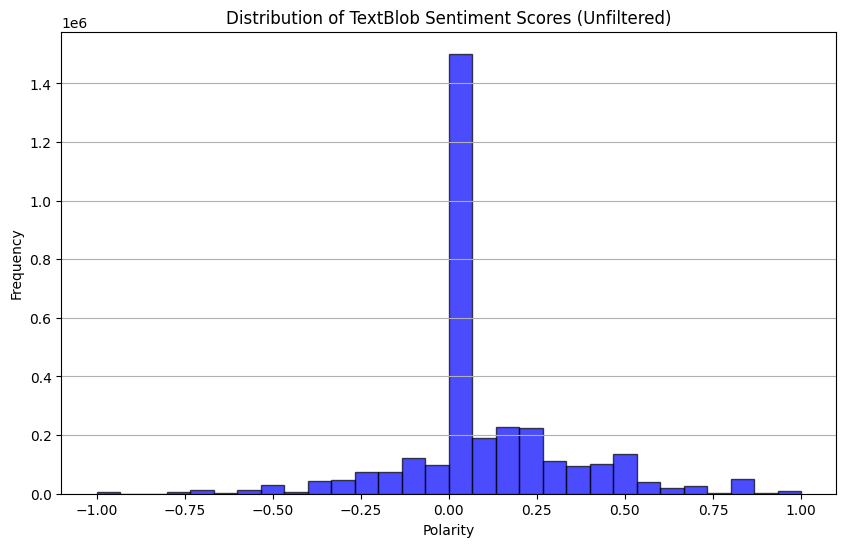

In [67]:
plt.figure(figsize=(10, 6))
plt.hist(unfiltered_tweets_df['textblob_polarity'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of TextBlob Sentiment Scores (Unfiltered)')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

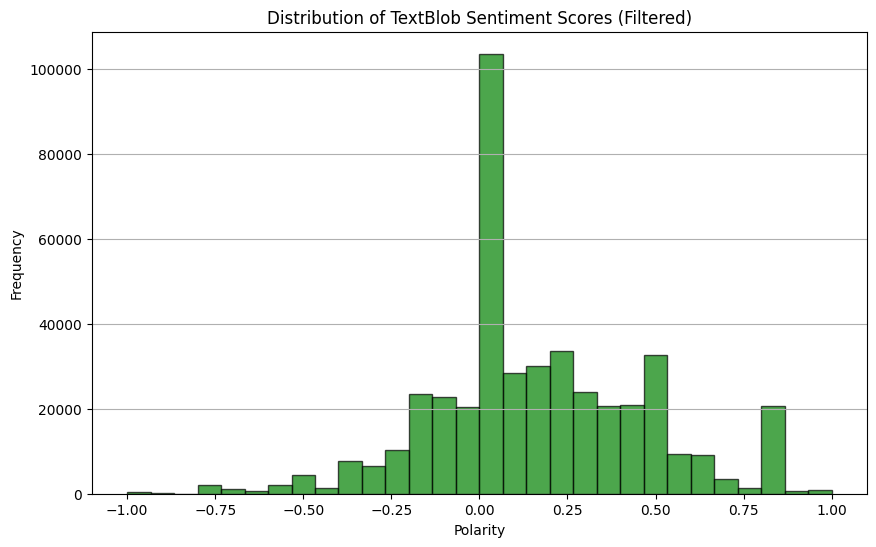

In [63]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_tweets_df['textblob_polarity'], bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of TextBlob Sentiment Scores (Filtered)')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

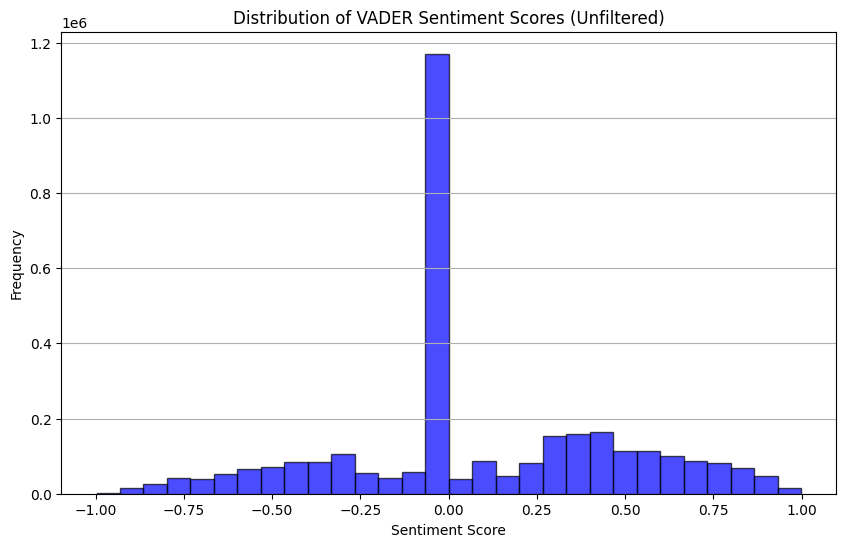

In [77]:
plt.figure(figsize=(10, 6))
plt.hist(unfiltered_tweets_df['vader_sentiment'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of VADER Sentiment Scores (Unfiltered)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

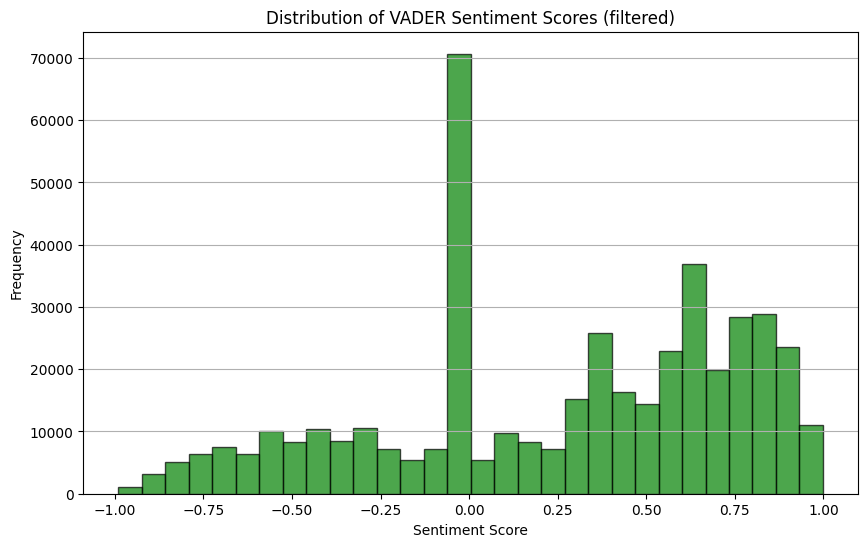

In [74]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_tweets_df['vader_sentiment'], bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of VADER Sentiment Scores (filtered)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

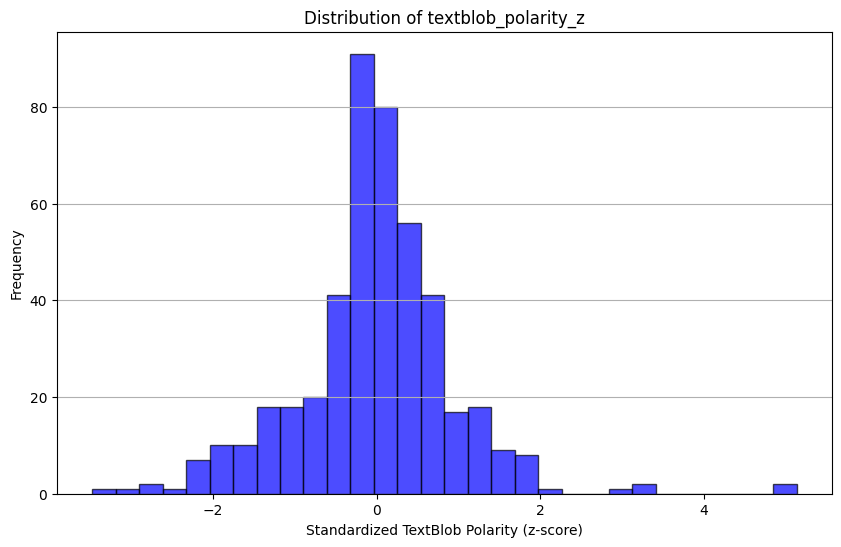

In [68]:
plt.figure(figsize=(10, 6))
plt.hist(unfiltered_final_df['textblob_polarity_z'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of textblob_polarity_z')
plt.xlabel('Standardized TextBlob Polarity (z-score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

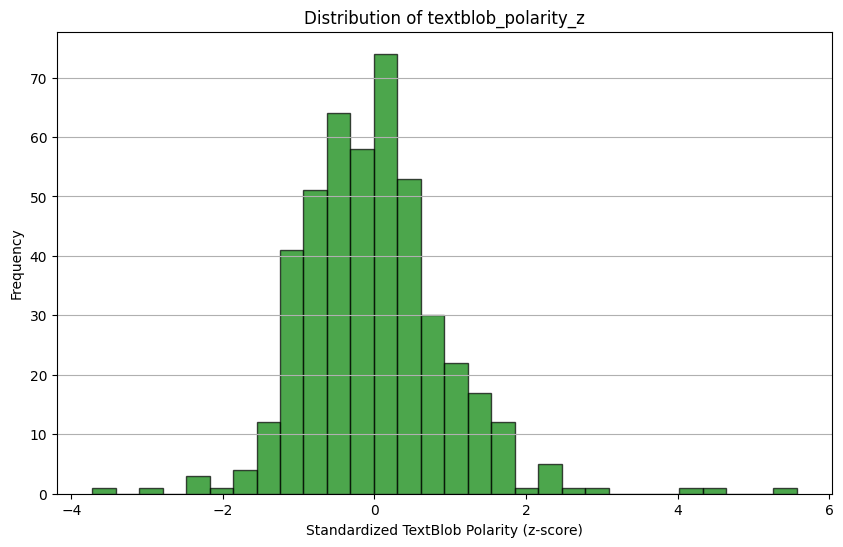

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_final_df['textblob_polarity_z'], bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of textblob_polarity_z')
plt.xlabel('Standardized TextBlob Polarity (z-score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

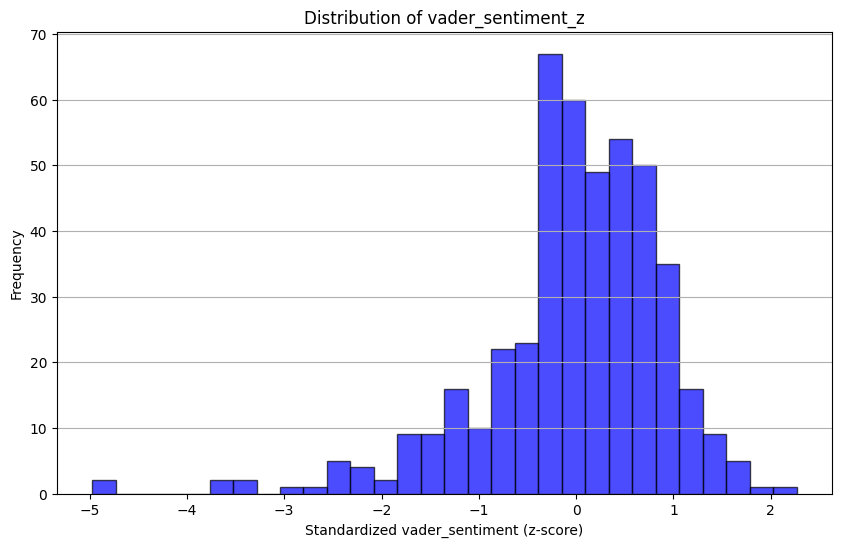

In [75]:
plt.figure(figsize=(10, 6))
plt.hist(unfiltered_final_df['vader_sentiment_z'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of vader_sentiment_z')
plt.xlabel('Standardized vader_sentiment (z-score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

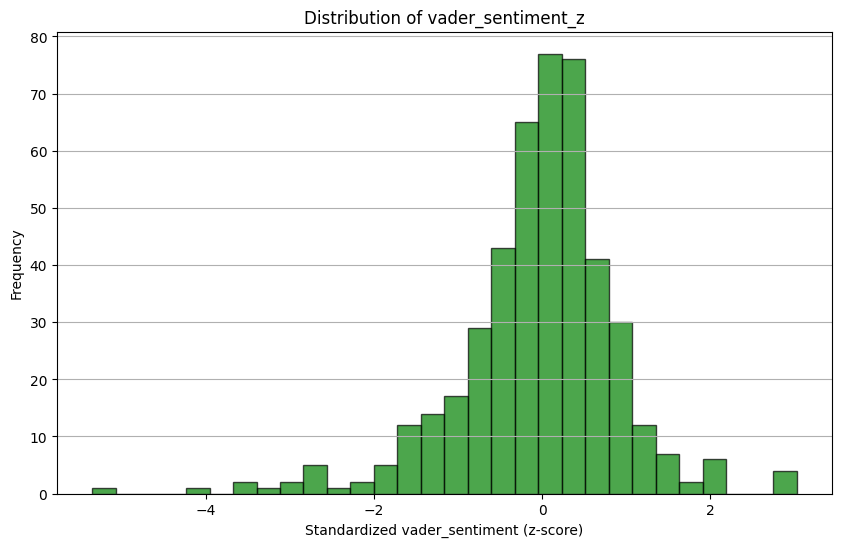

In [76]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_final_df['vader_sentiment_z'], bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of vader_sentiment_z')
plt.xlabel('Standardized vader_sentiment (z-score)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [79]:
filtered_final_df.to_csv('/Users/miali/Downloads/filtered_tweets_revised_2018_2020.csv', index=False)

In [73]:
unfiltered_tweets_df.to_csv('/Users/miali/Downloads/unfiltered_tweets_revised.csv', index=False)